<a href="https://colab.research.google.com/github/galbendavids/CLALIT_DE_and_analytics_pipeline/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pathlib
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
import glob
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from IPython import display

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
"""
def df_with_one_hot_endcoding(df):
  one_hot_encoded_df = pd.get_dummies(df)
  return one_hot_encoded_df
"""  

def udummy_german_credit(german_credit_df_new):
    german_credit_df_new_copy = german_credit_df_new.copy()
    for col_number in [1, 3, 4, 6, 7, 9, 10, 12, 14, 15, 17, 19, 20, 21]:
        start = None
        end = None
        col_to_remove = []
        for counter, col in enumerate(german_credit_df_new.columns):
            if f"{col_number}_b" in col:
                col_to_remove.append(col)
                if start is None:
                    start = counter
            elif start is not None:
                end = counter
                german_credit_df_new_copy[f'{col_number}'] = (german_credit_df_new.iloc[:, start:end]).idxmax(1)
                german_credit_df_new_copy.drop(col_to_remove, axis=1, inplace=True)
                break
            if f"{col_number}_b" in col and (counter + 1) == len(german_credit_df_new.columns):
                end = counter
                german_credit_df_new_copy[f'{col_number}'] = (german_credit_df_new.iloc[:, start:end]).idxmax(1)
                german_credit_df_new_copy.drop(col_to_remove, axis=1, inplace=True)
                break
    return german_credit_df_new_copy

In [ ]:
def read_and_normlize_dataset(name):
    if name == "diabetes":
        dataset = arff.loadarff('/content/drive/MyDrive/deep4/diabetes.arff')
        datasets_df = pd.DataFrame(dataset[0])
        dataset_without_label = datasets_df.iloc[:, :-1]
        scaler = StandardScaler()
        dataset_without_label[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]] = scaler.fit_transform(dataset_without_label[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]])
        return dataset_without_label.to_numpy(), scaler, dataset_without_label.columns
    else:
        dataset = arff.loadarff('/content/drive/MyDrive/deep4/german_credit.arff')
        datasets_df = pd.DataFrame(dataset[0])
        dataset_without_label = datasets_df.iloc[:, :-1]
        dataset_one_hot_encodeing = pd.get_dummies(dataset_without_label)
        scaler = StandardScaler()
        dataset_one_hot_encodeing[["2","5","8","11","13","16","18"]] = scaler.fit_transform(dataset_one_hot_encodeing[["2","5","8","11","13","16","18"]])
        return dataset_one_hot_encodeing.to_numpy(), scaler, dataset_one_hot_encodeing.columns
        

In [ ]:
def create_generator_model(input_shape, layer_dim, output_dim):
    # TODO change
    input= tf.keras.layers.Input(shape=input_shape)
    layer_output = tf.keras.layers.Dense(layer_dim, activation="relu")(input)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(output_dim)(layer_output)
    return tf.keras.Model(inputs=input, outputs=layer_output)

def create_discriminator_model(input_shape, layer_dim):
    input = tf.keras.layers.Input(shape=input_shape)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(input)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_output)
    return tf.keras.Model(inputs=input, outputs=layer_output)

def create_generator_model_credit(input_shape, layer_dim, output_dim):
    # TODO change
    input= tf.keras.layers.Input(shape=input_shape)
    layer_output = tf.keras.layers.Dense(layer_dim, activation="relu")(input)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(output_dim)(layer_output)
    return tf.keras.Model(inputs=input, outputs=layer_output)

def create_discriminator_model_credit(input_shape, layer_dim):
    input = tf.keras.layers.Input(shape=input_shape)
    layer_output = tf.keras.layers.Dense(layer_dim * 5, activation='relu')(input)
    layer_output = tf.keras.layers.Dense(layer_dim * 5, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output) # remove
    layer_output = tf.keras.layers.Dense(layer_dim, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_output)
    return tf.keras.Model(inputs=input, outputs=layer_output)

def discriminator_loss(real_data_disc_output, fake_data_disc_output, bce):
    real_data_loss = bce(tf.ones_like(real_data_disc_output), real_data_disc_output)
    fake_data_loss = bce(tf.zeros_like(fake_data_disc_output), fake_data_disc_output)
    loss = real_data_loss + fake_data_loss
    return loss

def generator_loss(fake_data_disc_output, bce):
    return bce (tf.ones_like(fake_data_disc_output), fake_data_disc_output)

In [ ]:
def train_step(samples, generator, discriminator, batch_size, input_shape, generator_optimizer, discriminator_optimizer, bce):
    noise = tf.random.normal([batch_size, input_shape])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_samples = generator(noise, training=True)

      real_data_disc_output = discriminator(samples, training=True)
      fake_data_disc_output = discriminator(generated_samples, training=True)
      gen_loss = generator_loss(fake_data_disc_output, bce)
      disc_loss = discriminator_loss(real_data_disc_output, fake_data_disc_output, bce)

    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train_model(name, epochs, input_shape):
    dataset, scaler, columes = read_and_normlize_dataset(name)
    output_dim = dataset.shape[1]
    batch_size = 32

    if name == "german_credit":
        layer_size_gen = 1024
        layer_size_disc = 256
        disc_lr = 1e-4
        gen_lr = 1e-4
        generator = create_generator_model_credit((input_shape, ), layer_size_gen, output_dim)
        discriminator = create_discriminator_model_credit((output_dim, ), layer_size_disc)
    else: # diabetes
        layer_size_gen = 128
        layer_size_disc = 256
        disc_lr = 1e-5
        gen_lr = 1e-5
        generator = create_generator_model((input_shape, ), layer_size_gen, output_dim)
        discriminator = create_discriminator_model((output_dim, ), layer_size_disc)

    train_dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
    
    generator_optimizer = tf.keras.optimizers.Adam(gen_lr)
    discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)
    history = {}
    history["gen"] = []
    history["disc"] = [] 
    bce = tf.keras.losses.BinaryCrossentropy()
    for epoch in range(epochs):
        for samples_batch in train_dataset:
            gen_loss, disc_loss = train_step(samples_batch, generator, discriminator, batch_size, input_shape, generator_optimizer, discriminator_optimizer, bce)
      
        history["gen"].append(gen_loss.numpy())
        history["disc"].append(disc_loss.numpy())  
        print(f"reach epoch number {epoch + 1}")
    return history, generator, discriminator, scaler, columes

In [ ]:
def plot(history):
    """ 
    this method plot the accuracy and the loss of the network
    """
    plt.plot(history['gen'])
    plt.plot(history['disc'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['gen', 'disc'])
    plt.show()

In [ ]:
def label_samples(generator, discriminator, generator_output):
    samples_label_as_real_index = []
    samples_label_as_fake_index = []
    
    for index, sample in enumerate(generator_output):
        if discriminator(np.array([sample])) > 0.5:
            samples_label_as_real_index.append(index)
        else:
            samples_label_as_fake_index.append(index)
    return samples_label_as_real_index, samples_label_as_fake_index

def print_results(history, name, num_examples_to_generate, dataset_columns, generator, discriminator, input_shape, scaler):
    plot(history)
    seed = tf.random.normal([num_examples_to_generate, input_shape])
    generator_output = generator(seed).numpy()
    df = pd.DataFrame(data= generator_output.copy(), columns=dataset_columns)
    if name == "german_credit":
        df[["2","5","8","11","13","16","18"]] = scaler.inverse_transform(df[["2","5","8","11","13","16","18"]])
        samples_label_as_real, samples_label_as_fake = label_samples(generator, discriminator, generator_output)
        print("number of output the bit the discriminator")
        print(len(samples_label_as_real))
        undummy_df = udummy_german_credit(df)
        return_value = (undummy_df, undummy_df.iloc[samples_label_as_real],
                        undummy_df.iloc[samples_label_as_fake], generator_output[samples_label_as_real],
                        generator_output[samples_label_as_fake])
        return return_value
    else:
        df[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]] = scaler.inverse_transform(df[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]])
        samples_label_as_real, samples_label_as_fake = label_samples(generator, discriminator, generator_output)
        print("number of output the bit the discriminator")
        print(len(samples_label_as_real))
        return_value = (df, df.iloc[samples_label_as_real],
                        df.iloc[samples_label_as_fake], generator_output[samples_label_as_real],
                        generator_output[samples_label_as_fake])
        return return_value

In [ ]:
EPOCHS=200
history, generator, discriminator,scaler, columes = train_model("german_credit", EPOCHS, 128)
results = print_results(history, "german_credit", 100, columes, generator, discriminator, 128, scaler)
df, samples_label_as_real_norm, samples_label_as_fake_norm, samples_label_as_real, samples_label_as_fake = results
#tf.keras.utils.plot_model(generator, show_shapes=True)
#tf.keras.utils.plot_model(discriminator, show_shapes=True)
df

reach epoch number 1
reach epoch number 2
reach epoch number 3
reach epoch number 4
reach epoch number 5
reach epoch number 6
reach epoch number 7


KeyboardInterrupt: ignored

In [ ]:
samples_label_as_real_norm

NameError: ignored

reach epoch number 1
reach epoch number 2
reach epoch number 3
reach epoch number 4
reach epoch number 5
reach epoch number 6
reach epoch number 7
reach epoch number 8
reach epoch number 9
reach epoch number 10
reach epoch number 11
reach epoch number 12
reach epoch number 13
reach epoch number 14
reach epoch number 15
reach epoch number 16
reach epoch number 17
reach epoch number 18
reach epoch number 19
reach epoch number 20
reach epoch number 21
reach epoch number 22
reach epoch number 23
reach epoch number 24
reach epoch number 25
reach epoch number 26
reach epoch number 27
reach epoch number 28
reach epoch number 29
reach epoch number 30
reach epoch number 31
reach epoch number 32
reach epoch number 33
reach epoch number 34
reach epoch number 35
reach epoch number 36
reach epoch number 37
reach epoch number 38
reach epoch number 39
reach epoch number 40
reach epoch number 41
reach epoch number 42
reach epoch number 43
reach epoch number 44
reach epoch number 45
reach epoch number 

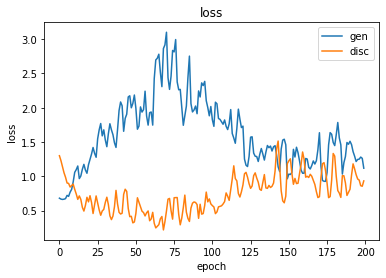

number of output the bit the discriminator
14


,preg,plas,pres,skin,insu,mass,pedi,age
0,1.197746,129.500336,70.859642,7.744060,94.191544,25.688812,0.513891,15.733748
1,4.603326,101.401154,74.200607,43.654385,211.203506,33.722027,0.178591,27.395844
2,2.884568,147.182922,62.930630,2.767864,32.434448,30.658863,0.006352,29.263535
3,4.864655,118.750175,74.907166,-5.723094,-4.739881,23.945332,0.202410,27.512581
4,0.274758,125.328522,63.337803,4.678903,113.453300,20.786207,0.701046,7.099045
...,...,...,...,...,...,...,...,...
95,3.259089,106.374138,64.415222,13.821465,107.025681,21.793312,0.307065,19.401506
96,0.821818,110.056335,57.391197,8.684026,145.519150,20.762579,0.401201,15.455724
97,4.369848,160.753174,80.459763,30.330416,167.491882,40.542435,0.183228,34.074085
98,5.108668,88.636391,67.404945,7.661384,82.761925,24.123569,0.346594,27.550465


In [ ]:
EPOCHS=200
history, generator, discriminator,scaler, columes  = train_model("diabetes", EPOCHS, 64)
results = print_results(history, "diabetes", 100, columes, generator, discriminator, 64, scaler)
df, samples_label_as_real_norm, samples_label_as_fake_norm, samples_label_as_real, samples_label_as_fake = results
#tf.keras.utils.plot_model(generator, show_shapes=True)
#tf.keras.utils.plot_model(discriminator, show_shapes=True)
df

In [ ]:
# random forest part

In [ ]:
# part 2

In [ ]:
def train_random_forest(name):
    if name == "diabetes":
        dataset = arff.loadarff('/content/drive/MyDrive/deep4/diabetes.arff')
        datasets_df = pd.DataFrame(dataset[0])
        dataset_encode_label = datasets_df.copy()
        dataset_encode_label["class"].replace({b"tested_negative": 0, b"tested_positive": 1}, inplace=True)
        features_cols = dataset_encode_label.iloc[: , :-1]
        label_col = dataset_encode_label.iloc[: , -1]
        X_train, X_test, y_train, y_test = train_test_split(features_cols, label_col, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=500, class_weight={0: 1, 1: 2})
        clf.fit(X_train, y_train)
        pred = clf.predict(scaler.transform(X_test))
        print(accuracy_score(y_test, pred))
        return features_cols, scaler, features_cols.columns, clf
    else:
        dataset = arff.loadarff('/content/drive/MyDrive/deep4/german_credit.arff')
        datasets_df = pd.DataFrame(dataset[0])
        dataset_encode_label = datasets_df.copy()
        dataset_encode_label["21"].replace({b"1": 0, b"2": 1}, inplace=True)
        dataset_encode_label = pd.get_dummies(dataset_encode_label)
        label_col = dataset_encode_label["21"]
        features_cols = dataset_encode_label.drop(["21"], axis=1)
        scaler = StandardScaler()
        X_train, X_test, y_train, y_test = train_test_split(features_cols, label_col, test_size=0.3, random_state=42)
        X_train_scale = X_train.copy()
        X_train_scale[["2","5","8","11","13","16","18"]] = scaler.fit_transform(X_train[["2","5","8","11","13","16","18"]])
        clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=500)
        clf.fit(X_train_scale, y_train)
        X_test_scale = X_test.copy()
        X_test_scale[["2","5","8","11","13","16","18"]] = scaler.transform(X_test[["2","5","8","11","13","16","18"]])
        pred = clf.predict(X_test_scale)
        print(accuracy_score(y_test, pred))
        return features_cols, scaler, features_cols.columns, clf

In [ ]:
def make_generator_model_part2(input_shape, layer_dim, output_dim):
    # TODO change
    input= tf.keras.layers.Input(shape=input_shape)
    input1= tf.keras.layers.Input(shape=(1, ))
    embedding = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(2, input_shape[0])(input1))
    dense = tf.keras.layers.Dense(embedding.shape[1])(embedding)
    layer_output = tf.keras.layers.concatenate([input, dense])
    layer_output = tf.keras.layers.Dense(layer_dim, activation="relu")(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output) # new add
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(output_dim)(layer_output)
    return tf.keras.Model(inputs=[input, input1], outputs=layer_output)
    

def make_generator_model_credit_part2(input_shape, layer_dim, output_dim):
    # TODO change
    input= tf.keras.layers.Input(shape=input_shape)
    input1= tf.keras.layers.Input(shape=(1, ))
    embedding = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(2, input_shape[0])(input1))
    dense = tf.keras.layers.Dense(embedding.shape[1])(embedding)
    layer_output = tf.keras.layers.concatenate([input, dense])
    layer_output = tf.keras.layers.Dense(layer_dim, activation="relu")(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 2, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 2, activation='relu')(layer_output) # new add
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(output_dim)(layer_output)
    return tf.keras.Model(inputs=[input, input1], outputs=layer_output)

def make_discriminator_model_part2(input_shape, layer_dim):
    input= tf.keras.layers.Input(shape=input_shape)
    input1= tf.keras.layers.Input(shape=(1, ))
    input2 = tf.keras.layers.Input(shape=(1, ))
    
    embedding = tf.keras.layers.Embedding(2, input_shape[0])
    embedding1 = tf.keras.layers.Flatten()(embedding(input1))
    embedding2 = tf.keras.layers.Flatten()(embedding(input2))
    z = tf.keras.layers.concatenate([embedding1, embedding2])
    dense = tf.keras.layers.Dense(z.shape[1])(z) # TODO think
    layer_output = tf.keras.layers.concatenate([input, dense])

    layer_output = tf.keras.layers.Dense(layer_dim * 4, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output) # remove
    layer_output = tf.keras.layers.Dense(layer_dim, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_output)
    return tf.keras.Model(inputs=[input, input1, input2], outputs=layer_output)

def make_discriminator_model_part2_credit(input_shape, layer_dim):
    input= tf.keras.layers.Input(shape=input_shape)
    input1= tf.keras.layers.Input(shape=(1, ))
    input2 = tf.keras.layers.Input(shape=(1, ))
    
    embedding = tf.keras.layers.Embedding(2, input_shape[0])
    embedding1 = tf.keras.layers.Flatten()(embedding(input1))
    embedding2 = tf.keras.layers.Flatten()(embedding(input2))
    z = tf.keras.layers.concatenate([embedding1, embedding2])
    dense = tf.keras.layers.Dense(z.shape[1])(z) # TODO think
    layer_output = tf.keras.layers.concatenate([input, dense])

    layer_output = tf.keras.layers.Dense(layer_dim * 3, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 2, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(layer_dim * 2, activation='relu')(layer_output) # remove
    layer_output = tf.keras.layers.Dense(layer_dim, activation='relu')(layer_output)
    layer_output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_output)
    return tf.keras.Model(inputs=[input, input1, input2], outputs=layer_output)

In [ ]:
def discriminator_loss_part2(output_disc, real):
    return tf.keras.losses.BinaryCrossentropy()(output_disc, real)
def generator_loss_part2(output_disc, real):
    return tf.keras.losses.BinaryCrossentropy()(output_disc, real)

In [ ]:
def train_step_part2(counter, generator, discriminator, batch_size, input_shape, generator_optimizer, discriminator_optimizer, clf):
    
    noise = tf.random.normal([batch_size, input_shape])
    #conf = np.random.rand(BATCH_SIZE)
    conf = np.ones(batch_size) * np.random.rand(1)
    conf_clf = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_samples = generator([noise, conf], training=True)
      
      conf_clf = np.array([elem[1] for elem in clf.predict_proba(generated_samples.numpy())])
      gen_y = np.zeros(batch_size)
      dec_y = np.ones(batch_size)
      # TODO check if must
      """
      replace = np.random.randint(2, 4)
      for i in range(batch_size):
          if i % replace == 0:
              temp = conf[i]
              conf[i] = conf_clf[i]
              conf_clf[i] = temp
              dec_y[i] == 0
              gen_y[i] == 1
      """
      
      if counter %2 ==0:
          output = discriminator([generated_samples, conf_clf, conf], training=True)
          gen_loss = generator_loss_part2(output, gen_y)
          disc_loss = discriminator_loss_part2(output, dec_y)
      else:
          output = discriminator([generated_samples, conf, conf_clf], training=True)
          gen_loss = generator_loss_part2(output, dec_y)
          disc_loss = discriminator_loss_part2(output, gen_y)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train_model_part2(name, epochs, input_shape):
    dataset, scaler, columes, clf = train_random_forest(name)
    output_dim = dataset.shape[1]
    #buffer_size = 500 TODO check
    batch_size = 32

    if name == "german_credit":
        layer_size_gen = 256
        layer_size_disc = 128
        disc_lr = 1e-4
        gen_lr = 1e-4
        generator = make_generator_model_part2((input_shape, ), layer_size_gen, output_dim)
    else:
        layer_size_gen = 256
        layer_size_disc = 256
        disc_lr = 1e-5
        gen_lr = 1e-3
        generator = make_generator_model_part2((input_shape, ), layer_size_gen, output_dim)
    
    
    train_dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
    
    discriminator = make_discriminator_model_part2((output_dim, ), layer_size_disc)
    generator_optimizer = tf.keras.optimizers.Adam(gen_lr)
    discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr)
    history = {}
    history["gen"] = []
    history["disc"] = []
    counter = 0 
    for epoch in range(epochs):
        for _ in train_dataset:
            gen_loss, disc_loss = train_step_part2(counter, generator, discriminator, batch_size, input_shape, generator_optimizer, discriminator_optimizer, clf)
            counter += 1
      
        history["gen"].append(gen_loss.numpy())
        history["disc"].append(disc_loss.numpy())
        print(f"reach epoch number {epoch + 1}")
    return history, generator, discriminator, scaler, columes, clf

In [ ]:
def print_results_part2(history, name, num_examples_to_generate, dataset_columns, generator, discriminator, input_shape, scaler):
    plot(history)
    if name == "german_credit":
        seed = tf.random.normal([num_examples_to_generate, input_shape])
        conf = np.random.rand(num_examples_to_generate , 1)
        generator_output = generator([seed, conf]).numpy()
        df = pd.DataFrame(data= generator_output.copy(), columns=dataset_columns)
        df[["2","5","8","11","13","16","18"]] = scaler.inverse_transform(df[["2","5","8","11","13","16","18"]])
        #print("number of output the bit the discriminator")
        #print((discriminator(generator_output)>0.5).numpy().sum())
        return udummy_german_credit(df), generator_output, conf
    else:
        seed = tf.random.normal([num_examples_to_generate, input_shape])
        conf = np.random.rand(num_examples_to_generate , 1)
        generator_output = generator([seed, conf]).numpy()
        df = pd.DataFrame(data= generator_output.copy(), columns=dataset_columns)
        df[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]] = scaler.inverse_transform(df[['preg', 'plas', 'pres', 'skin', "insu", "mass", "pedi", "age"]])
        #print("number of output the bit the discriminator")
        #print((discriminator(generator_output)>0.5).numpy().sum())
        return df, generator_output, conf

In [ ]:
EPOCHS=100
history, generator, discriminator, scaler, columes, clf = train_model_part2("german_credit", EPOCHS, 256)
df, samples, conf = print_results_part2(history, "german_credit", 32, columes, generator, discriminator, 256, scaler) 
#tf.keras.utils.plot_model(generator, show_shapes=True)
#tf.keras.utils.plot_model(discriminator, show_shapes=True)
#clf.predict_proba(samples[0:30])

0.7133333333333334
reach epoch number 1
reach epoch number 2
reach epoch number 3
reach epoch number 4
reach epoch number 5
reach epoch number 6
reach epoch number 7
reach epoch number 8


KeyboardInterrupt: ignored

In [ ]:
EPOCHS=120
history, generator, discriminator, scaler, columes, clf = train_model_part2("diabetes", EPOCHS, 128)
df, samples, conf = print_results_part2(history, "diabetes", 32, columes, generator, discriminator, 128, scaler)
clf.predict_proba(samples[0:30])

In [ ]:
while True:
    pass

In [ ]:
print("seed")
#seed = tf.random.normal([1, INPUT_SHAPE])
noise = tf.random.normal([32, 128])
#print(noise)
conf = np.random.rand(32 , 1)
#print(conf)
#s = generator1([noise, np.array([0.3])])
s = generator([noise, conf])
#print(s)

#print(clf.predict_proba(s.numpy()))
print(clf.predict_proba(s.numpy()))
#print(scaler.inverse_transform(s.numpy()).round(3))
#(discriminator(generator(seed))>0.5).numpy().sum()
#print(discriminator1([s, np.array([0.1]), np.array([0.2])]))

#scaler.inverse_transform(diabetes_df_new_new)